In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

## Carregando e preparando os dados

In [6]:
# carregando os dados
file_path = './alzheimer_disease_dataset/alzheimers_disease_data.csv'
data = pd.read_csv(file_path)

In [7]:
# removendo colunas irrelevantes
data = data.drop(columns=['PatientID', 'DoctorInCharge'])
print(data.columns.tolist())

['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis']


In [11]:
# separando características e alvo
X = data.drop(columns=['Diagnosis']) # recursos -> todas as colunas menos a Diagnosis
y = data['Diagnosis']

# dividindo os dados em treino e em teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalizando as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Validação Cruzada para KNN

Melhor valor de K: 19


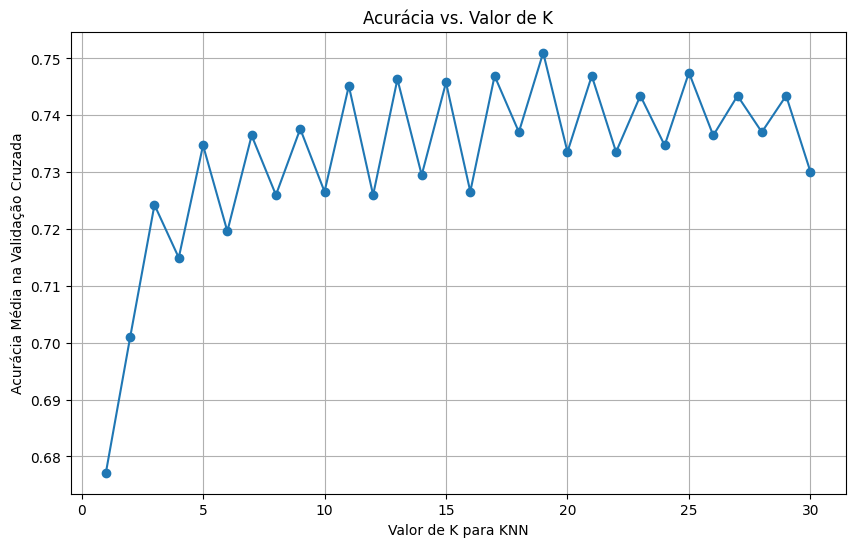

In [20]:
# buscando o melhor valor de k
k_range = range(1, 31)
k_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')
  k_scores.append(scores.mean())

# encontrando o melhor k
best_k = k_range[np.argmax(k_scores)]
print(f"Melhor valor de K: {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia Média na Validação Cruzada')
plt.title('Acurácia vs. Valor de K')
plt.grid(True)
plt.show()

## Treinando o modelo

In [14]:
# treinando o modelo KNN com o melhor k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# avaliando o modelo
accuracy = knn.score(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste: {accuracy}")

Acurácia no conjunto de teste: 0.7441860465116279


## Avaliando o modelo

In [18]:
y_pred = knn.predict(X_test_scaled)

# relatório de classificação e matriz de confusão
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Relatório de Classificação no Modelo KNN:\n", report)
print("Matriz de Confusão no modelo KNN:\n", conf_matrix)

# calculando o Specificity
TN = conf_matrix[0, 0] # true negatives
FP = conf_matrix[0, 1] # false positives
FN = conf_matrix[1, 0] # false negatives
TP = conf_matrix[1, 1] # true positives

specificity = TN / (TN + FP)
print(f"\nSpecificity: {specificity:.2f}")

Relatório de Classificação no Modelo KNN:
               precision    recall  f1-score   support

           0       0.73      0.95      0.83       277
           1       0.79      0.38      0.51       153

    accuracy                           0.74       430
   macro avg       0.76      0.66      0.67       430
weighted avg       0.76      0.74      0.72       430

Matriz de Confusão no modelo KNN:
 [[262  15]
 [ 95  58]]

Specificity: 0.95
